In [19]:
# import networkx
import rustworkx as rx
from rustworkx.visualization import graphviz_draw
from rustworkx.visualization import mpl_draw
import networkx as nx
import lovelyplots
import scienceplots

In [20]:
import networkx as nx
import matplotlib.pyplot as plt


class QuantumModuleGraph:
    """A class representing a quantum module with:
    - N qubits (green nodes)
    - 1 SNAIL mode (red node)
    - Qubit-qubit interactions (blue edges)
    - Snail-qubit interactions (orange edges)
    """

    def __init__(self, qubit_frequencies, snail_frequency):
        """Initializes a quantum module graph with only qubit-qubit and snail-qubit interactions.

        Args:
            qubit_frequencies (list): List of qubit bare frequencies in GHz.
            snail_frequency (float): SNAIL bare frequency in GHz.
        """
        self.G = nx.Graph()
        self.qubit_frequencies = qubit_frequencies
        self.snail_frequency = snail_frequency

        # Build the graph structure
        self._add_nodes()
        self._add_edges()

    def _add_nodes(self):
        """Adds qubits and the SNAIL as nodes in the graph."""
        for i, freq in enumerate(self.qubit_frequencies):
            self.G.add_node(f"Q{i}", type="qubit", bare_frequency=freq, color="green")
        self.G.add_node(
            "SNAIL", type="snail", bare_frequency=self.snail_frequency, color="red"
        )

    def _add_edges(self):
        """Adds only qubit-qubit and snail-qubit interactions as edges."""
        num_qubits = len(self.qubit_frequencies)

        # Qubit-qubit interactions (blue edges)
        for i in range(num_qubits):
            for j in range(i + 1, num_qubits):
                self.G.add_edge(
                    f"Q{i}", f"Q{j}", interaction="qubit-qubit", color="blue"
                )

        # Qubit-SNAIL interactions (orange edges)
        for i in range(num_qubits):
            self.G.add_edge(f"Q{i}", "SNAIL", interaction="snail-qubit", color="orange")

    def get_interaction_frequencies(self):
        """Computes interaction frequencies, tracking edges for direct interactions
        and storing subharmonics separately.
        """
        interaction_freqs = {
            "qubit-qubit": {},  # { (Q0, Q1): freq_diff }
            "snail-qubit": {},  # { (Q2, SNAIL): freq_diff }
            "qubit-sub": {},  # { Q0: freq/2 }
            "snail-sub": {},  # { SNAIL: freq/2 }
            "qubit-resonance": {},  # { Q0: freq }
            "snail-resonance": {},  # { SNAIL: freq }
            # Intermodule placeholders for future updates
            "snail-qubit (inter)": {},
            "qubit-sub (inter)": {},
        }

        # Store interaction frequencies for qubit-qubit and snail-qubit edges
        for u, v in self.G.edges:
            f_u = self.G.nodes[u]["bare_frequency"]
            f_v = self.G.nodes[v]["bare_frequency"]
            freq_diff = abs(f_u - f_v)

            interaction_type = self.G.edges[u, v]["interaction"]

            if interaction_type in ["qubit-qubit", "snail-qubit"]:
                interaction_freqs[interaction_type][(u, v)] = freq_diff

        # Store individual qubit resonances and subharmonics
        for node in self.G.nodes:
            node_type = self.G.nodes[node]["type"]
            freq = self.G.nodes[node]["bare_frequency"]

            if node_type == "qubit":
                interaction_freqs["qubit-resonance"][(node,)] = freq
                interaction_freqs["qubit-sub"][(node,)] = freq / 2

            elif node_type == "snail":
                interaction_freqs["snail-resonance"][(node,)] = freq
                interaction_freqs["snail-sub"][(node,)] = freq / 2

        return interaction_freqs

    def plot(self):
        """Plots the quantum module graph with specified node and edge colors."""
        pos = nx.spring_layout(self.G, seed=42)  # Layout for better visualization

        # Node colors
        node_colors = [self.G.nodes[node]["color"] for node in self.G.nodes]

        # Edge colors
        edge_colors = [self.G.edges[u, v]["color"] for u, v in self.G.edges]

        # Labels for nodes
        labels = {
            node: f"{node}\n{self.G.nodes[node]['bare_frequency']:.2f} GHz"
            for node in self.G.nodes
        }

        plt.figure(figsize=(5, 5))

        # Draw nodes
        nx.draw(
            self.G,
            pos,
            with_labels=True,
            labels=labels,
            node_size=2000,
            node_color=node_colors,
            edgecolors="black",
        )

        # Draw edges with specific colors
        nx.draw_networkx_edges(self.G, pos, edge_color=edge_colors, width=2)

        # Add edge labels
        edge_labels = {
            (u, v): self.G.edges[u, v]["interaction"] for u, v in self.G.edges
        }
        nx.draw_networkx_edge_labels(self.G, pos, edge_labels=edge_labels, font_size=8)

        plt.title("Quantum Module (SNAIL + Qubits)")
        plt.show()

    def plot_interaction_frequencies(self):
        """Plots the bare qubit frequencies, SNAIL frequency, and calculated interaction frequencies."""
        interaction_freqs = self.get_interaction_frequencies()
        all_freqs = list(interaction_freqs["qubit-resonance"].values()) + list(
            interaction_freqs["snail-resonance"].values()
        )

        with plt.style.context(["ieee", "use_mathtext", "science"]):
            fig, ax = plt.subplots(figsize=(3.5, 1))

            max_freq = max(all_freqs) * 1.1
            ax.set_xlim(0, max_freq)
            ax.get_yaxis().set_visible(False)

            # Prepare to track which labels have been added to avoid duplicates
            added_labels = set()

            # Updated Color Mapping
            color_map = {
                "qubit-qubit": "blue",
                "qubit-resonance": "green",
                "snail-qubit": "orange",
                "qubit-sub": "lightgreen",  # Qubit subharmonic in light green
                "snail-sub": "lightcoral",  # Snail subharmonic in light red
                "snail-resonance": "red",  # Snail resonance in red
            }

            # Plot interactions with color-coding
            for interaction_type, freqs in interaction_freqs.items():
                if not freqs:
                    continue

                color = color_map.get(interaction_type, "black")

                label = (
                    interaction_type.replace("-", " ").title()
                    if interaction_type not in added_labels
                    else ""
                )

                for freq in freqs.values():
                    ax.axvline(
                        freq,
                        color=color,
                        linestyle="-",
                        linewidth=2,
                        alpha=0.8,
                        label=label,
                    )
                    added_labels.add(interaction_type)

            ax.set_xlabel("Frequency (GHz)")
            handles, labels = plt.gca().get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            ax.legend(
                by_label.values(),
                by_label.keys(),
                loc="upper center",
                bbox_to_anchor=(0.5, -0.25),
                ncol=2,
                fontsize=10,
            )

        plt.show()

    def get_graph(self):
        """Returns the NetworkX graph object."""
        return self.G

In [21]:
from corral_crowding.detuning_fit import compute_infidelity_parameters, decay_fit
import numpy as np


class GateFidelityOptimizer:
    """Computes infidelity contributions and cost function for a given QuantumModuleGraph."""

    def __init__(self, module_graph, lambdaq=0.08, eta=1.8, alpha=120e6, g3=60e6):
        """Initializes the optimizer and precomputes infidelity parameters.

        Args:
            module_graph (QuantumModuleGraph): The quantum module to optimize.
            lambdaq, eta, alpha, g3: Physical parameters for infidelity computations.
        """
        self.module_graph = module_graph

        # Compute infidelity parameters once
        detuning_list = np.linspace(50, 1000, 64)
        self.infidelity_params, _ = compute_infidelity_parameters(
            detuning_list, lambdaq, eta, alpha, g3
        )

    def _unit_crosstalk(self, intended_freq, spectator_key, spectator_freq):
        """Compute infidelity contribution from a single spectator interaction."""
        distance = np.abs(intended_freq - spectator_freq)
        units_distance = distance * 1e3  # Convert GHz → MHz

        # Apply smoothing approximations
        if distance < 0.05:
            return 3  # Strong crosstalk penalty
        if distance > 0.6:
            return 0  # Negligible impact

        # Retrieve fit parameters for the interaction type
        params = self.infidelity_params.get(spectator_key)
        if params is None:
            raise KeyError(f"Unknown interaction type: {spectator_key}")

        a, b, c, d = params
        return decay_fit(units_distance, a, b, c, d)

    def compute_gate_infidelity(self, edge):
        """Computes the infidelity of a single driven two-qubit gate."""
        interaction_data = self.module_graph.get_interaction_frequencies()
        driven_freq = interaction_data["qubit-qubit"][edge]
        gate_infidelity = 0.0

        # Iterate over all relevant interaction types
        for interaction_type in ["qubit-qubit", "snail-qubit", "qubit-sub"]:
            for spectator_edge, spectator_freq in interaction_data[
                interaction_type
            ].items():
                if spectator_edge == edge:
                    continue  # Skip self-interaction
                gate_infidelity += self._unit_crosstalk(
                    driven_freq, interaction_type, spectator_freq
                )

        return gate_infidelity

    def compute_total_infidelity(self):
        """Computes total cost function by summing all gate infidelities."""
        interaction_data = self.module_graph.get_interaction_frequencies()
        gate_infidelities = {
            edge: self.compute_gate_infidelity(edge)
            for edge in interaction_data["qubit-qubit"]
        }

        return gate_infidelities, sum(gate_infidelities.values())

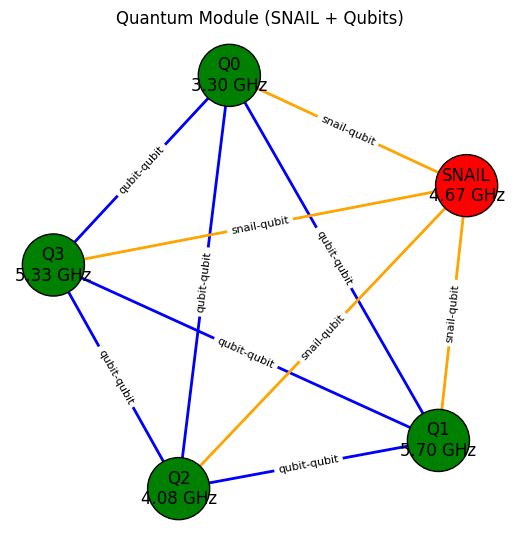

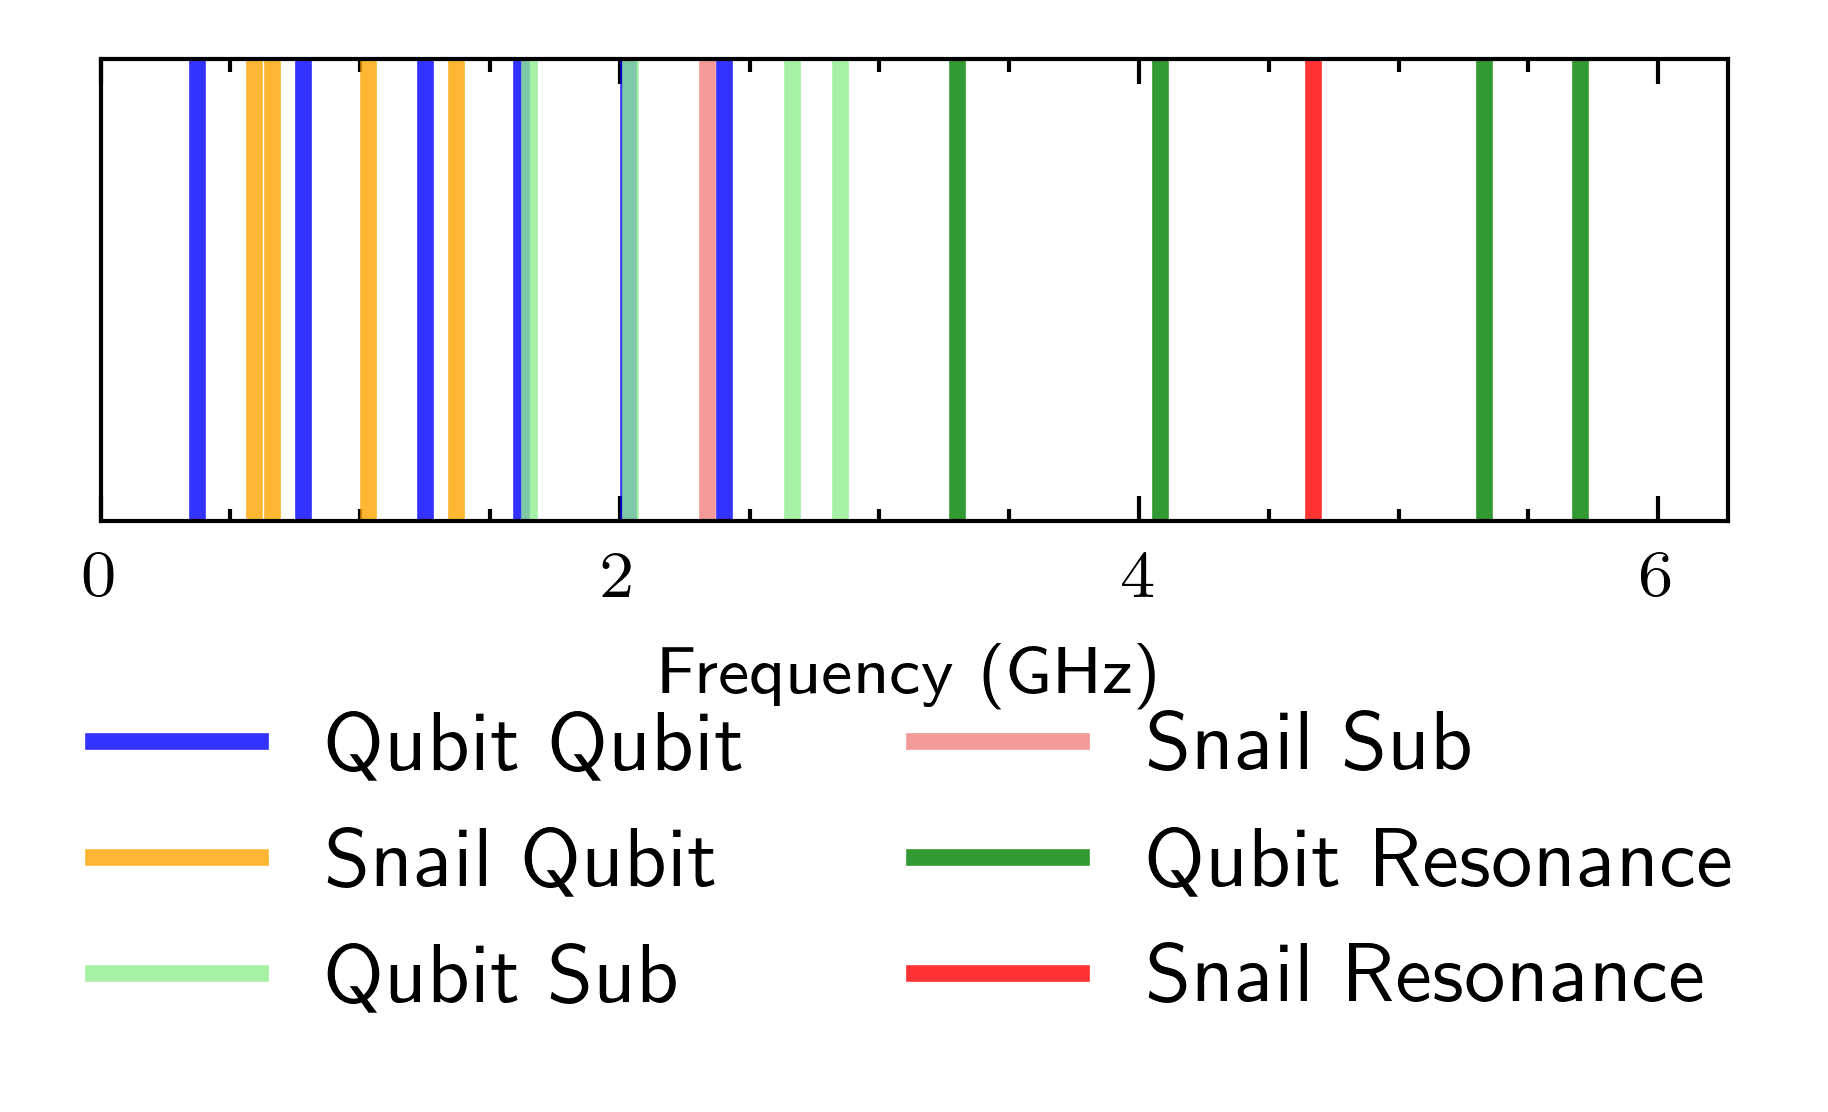

Gate Infidelities:
  Gate ('Q0', 'Q1') → Infidelity: 0.012925
  Gate ('Q0', 'Q2') → Infidelity: 0.207328
  Gate ('Q0', 'Q3') → Infidelity: 3.003342
  Gate ('Q1', 'Q2') → Infidelity: 3.036789
  Gate ('Q1', 'Q3') → Infidelity: 0.058651
  Gate ('Q2', 'Q3') → Infidelity: 0.168679

Total Gate Infidelity (Cost Function): 6.487716


/home/evm9/corral_crowding/src/corral_crowding/detuning_fit.py:28: RuntimeWarning: invalid value encountered in power
  return a * ((detuning + d) ** -b) + c


In [22]:
# Define qubit and SNAIL frequencies
bare_frequencies = [3.3, 5.7, 4.08, 5.33]  # GHz
snail_frequency = 4.67  # GHz

# Create a module graph
module = QuantumModuleGraph(bare_frequencies, snail_frequency)

# Plot the module (only showing qubit-qubit and snail-qubit interactions)
module.plot()

module.get_interaction_frequencies()

module.plot_interaction_frequencies()

# Initialize the fidelity optimizer
optimizer = GateFidelityOptimizer(module)

# Compute total infidelity
gate_infidelities, total_infidelity = optimizer.compute_total_infidelity()

# Print results
print("Gate Infidelities:")
for edge, infidelity in gate_infidelities.items():
    print(f"  Gate {edge} → Infidelity: {infidelity:.6f}")

print(f"\nTotal Gate Infidelity (Cost Function): {total_infidelity:.6f}")